### threshold analysis

In [1]:
import bisect
from scipy.stats import mstats
import pandas as pd
import numpy as np
import pathlib
import json
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import model

In [3]:
sns.set_style('darkgrid')

In [4]:
# https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415

Key points to bear in mind when setting a threshold:
- queue rate: how many cases do you want to act on? (i.e. what proportion of observations do you want to act on?)
- precision: What’s the downside when you erroneously queue a case? (e.g. wasted time of checking fraud targets, or, send a 10% discount coupon to someone that would've renewed anyway)
- recall: What’s the downside when you fail to queue a case that should have been queued? (what is the cost of having fraudulent accounts, or, customers not renewing.)

### load train & test data

In [5]:
data_train_df = pd.read_parquet("./output/data_train_df.parquet")
data_test_df = pd.read_parquet("./output/data_test_df.parquet")

#### recreate model

In [6]:
# load training_config.json into dictionary
with open("./output/marketing_model.json") as file:
    # Load its content and make a new dictionary
    training_config = json.load(file)

In [7]:
# create model with parameters
pipe_final_new = model.ClassificationModel(training_config)

In [8]:
# load trained model
pipe_final_new.load_model("./output/marketing_model")

2025-04-08 16:52:25.457 | INFO     | model:load_model:213 - Loaded sklearn pipeline from ./output/marketing_model.


#### run threshold simulations

In [9]:
# set simulation parameters
test_size_fraction = 0.5
n_trials = 3

In [10]:
# capture results
plot_data = []
# run simulation
for trial in range(n_trials):
    data_train_sample_df = data_test_df.sample(frac=test_size_fraction,random_state=trial).copy()
    pipe_final_new.fit(data_train_sample_df)
    predictions_sample_df = pipe_final_new.predict(data_test_df)
    precision, recall, thresholds = precision_recall_curve(predictions_sample_df.target, predictions_sample_df.prediction_probability)
    thresholds = np.append(thresholds, 1)
    
    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions_sample_df.prediction_probability >= threshold).mean())
            
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })  

2025-04-08 16:52:25.484 | INFO     | model:fit:117 - Starting training
2025-04-08 16:52:25.892 | INFO     | model:fit:138 - Training complete for all models.
2025-04-08 16:52:25.918 | INFO     | model:predict:155 - Computed predictions for 1799 records
2025-04-08 16:52:26.057 | INFO     | model:fit:117 - Starting training
2025-04-08 16:52:26.447 | INFO     | model:fit:138 - Training complete for all models.
2025-04-08 16:52:26.470 | INFO     | model:predict:155 - Computed predictions for 1799 records
2025-04-08 16:52:26.605 | INFO     | model:fit:117 - Starting training
2025-04-08 16:52:27.003 | INFO     | model:fit:138 - Training complete for all models.
2025-04-08 16:52:27.027 | INFO     | model:predict:155 - Computed predictions for 1799 records


#### plot simulation results

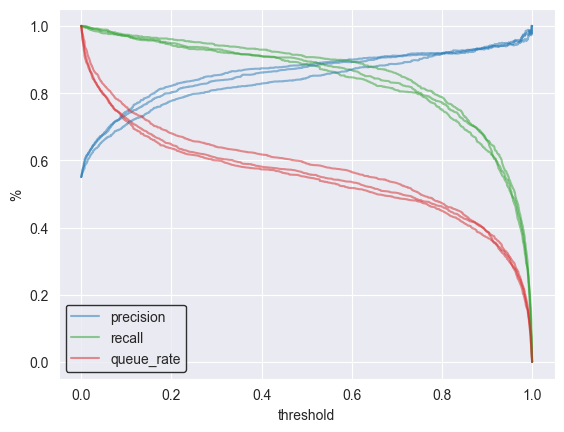

In [11]:

for p in plot_data:
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[2], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[3], alpha=0.5)
    
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')
plt.show()

#### summarise results

In [12]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []
uniform_recall_plots= []
uniform_queue_rate_plots= []

for p in plot_data:
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])
        
    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

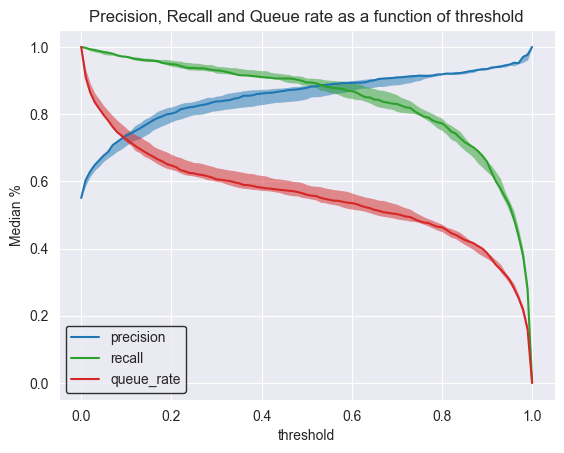

In [13]:
quantiles = [0.1, 0.5, 0.9]
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision, color=sns.color_palette()[0])
plt.plot(uniform_thresholds, median_recall, color=sns.color_palette()[2])
plt.plot(uniform_thresholds, median_queue_rate, color=sns.color_palette()[3])

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[2])
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[3])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.title("Precision, Recall and Queue rate as a function of threshold")
plt.xlabel('threshold')
plt.ylabel('Median %')
plt.show()

#### calculate and plot optimum threshold

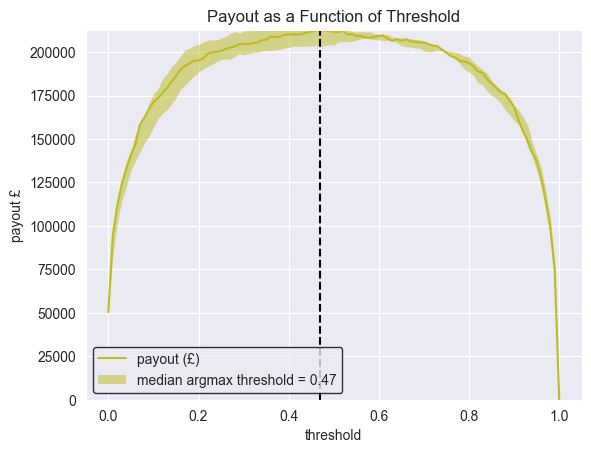

In [14]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_payout_plots = []

n = 10000
success_payoff = 100 # payoff when successfully targeted
case_cost = 50 # cost of processing each target case

for p in plot_data:
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        recall = p['recall'][index]
        # marketing new customer payout: profit payoff of successful target - cost of every target
        # fraud: every fraudulent customer successfully identified target saves some money, but there is a cost to investigate each target
        payout = n*queue_rate*(precision*success_payoff - case_cost) 
        
        uniform_payout.append(payout)

    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[8])
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[8])

max_ap = uniform_thresholds[np.argmax(median_payout)]
max_payout = np.max(median_payout)
plt.vlines([max_ap], 0, max_payout, linestyles='--',colors="black")
plt.ylim(0, max_payout)

leg = plt.legend(('payout (£)', 'median argmax threshold = {:.2f}'.format(max_ap)), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.title("Payout as a Function of Threshold")
plt.ylabel('payout £')
plt.show()

In [15]:
print(f"max payout: {np.max(median_payout):.1f}")

max payout: 212618.1


commentary:
- any observation with a probability above the threshold is a target
- when there is a large payoff of each target and low cost of processing each target, then recall is more important and the threshold probability is low (i.e. you falsely)
- when there is low payoff and high cost then precision is more important